In [70]:
import itertools
import os
import collections
import sys
import traceback
import matplotlib
import glypy
from glypy import monosaccharides
from glypy.composition import Composition, composition_transform
from glypy.structure import (glycan, monosaccharide, substituent,
                              Anomer, Configuration, SuperClass,
                              Substituent, Glycan, Monosaccharide,
                              crossring_fragments)
from glypy.io.nomenclature import identity
from glypy.io import glycoct, glycomedb
from glypy import plot
from glypy.algorithms import subtree_search, similarity, database
from glypy import tests
%matplotlib inline
from IPython.display import set_matplotlib_formats, display

set_matplotlib_formats("svg")

import logging
logging.basicConfig(level="DEBUG")

In [19]:
repeating_glycan = '''
RES
1b:a-dglc-HEX-1:5
2b:a-dglc-HEX-1:5
3r:r1
4b:b-dara-HEX-2:5|2:keto
LIN
1:1o(1+1)2d
2:2o(6+2)3n
3:3n(1+2)4d
REP
REP1:5o(1+2)5d=-1--1
RES
5b:b-dara-HEX-2:5|2:keto
'''

lactosamine_repeat = '''
RES
1b:b-dglc-HEX-1:5
2s:n-acetyl
3b:b-dglc-HEX-1:5
4s:n-acetyl
5b:b-dman-HEX-1:5
6b:a-dman-HEX-1:5
7b:b-dglc-HEX-1:5
8s:n-acetyl
9r:r1
10b:b-dgal-HEX-1:5
11b:a-dman-HEX-1:5
12b:b-dglc-HEX-1:5
13s:n-acetyl
14r:r2
15b:b-dgal-HEX-1:5
16b:a-lgal-HEX-1:5|6:d
LIN
1:1d(2+1)2n
2:1o(4+1)3d
3:3d(2+1)4n
4:3o(4+1)5d
5:5o(3+1)6d
6:6o(2+1)7d
7:7d(2+1)8n
8:7o(4+1)9n
9:9n(4+1)10d
10:5o(6+1)11d
11:11o(2+1)12d
12:12d(2+1)13n
13:12o(4+1)14n
14:14n(4+1)15d
15:1o(6+1)16d
REP
REP1:18o(4+1)17d=-1--1
RES
17b:b-dgal-HEX-1:5
18b:b-dglc-HEX-1:5
19s:n-acetyl
LIN
16:17o(3+1)18d
17:18d(2+1)19n
REP2:21o(4+1)20d=-1--1
RES
20b:b-dgal-HEX-1:5
21b:b-dglc-HEX-1:5
22s:n-acetyl
LIN
18:20o(3+1)21d
19:21d(2+1)22n
'''


lactosamine_from_source = '''
RES
1b:b-dglc-HEX-1:5
2s:n-acetyl
3b:b-dglc-HEX-1:5
4s:n-acetyl
5b:b-dman-HEX-1:5
6b:a-dman-HEX-1:5
7b:b-dglc-HEX-1:5
8s:n-acetyl
9r:r1
10b:b-dgal-HEX-1:5
11b:a-dman-HEX-1:5
12b:b-dglc-HEX-1:5
13s:n-acetyl
14r:r2
15b:b-dgal-HEX-1:5
16b:a-lgal-HEX-1:5|6:d
LIN
1:1d(2+1)2n
2:1o(4+1)3d
3:3d(2+1)4n
4:3o(4+1)5d
5:5o(3+1)6d
6:6o(2+1)7d
7:7d(2+1)8n
8:7o(4+1)9n
9:9n(4+1)10d
10:5o(6+1)11d
11:11o(2+1)12d
12:12d(2+1)13n
13:12o(4+1)14n
14:14n(4+1)15d
15:1o(6+1)16d
REP
REP1:18o(4+1)17d=-1--1
RES
17b:b-dgal-HEX-1:5
18b:b-dglc-HEX-1:5
19s:n-acetyl
LIN
16:17o(3+1)18d
17:18d(2+1)19n
REP2:21o(4+1)20d=-1--1
RES
20b:b-dgal-HEX-1:5
21b:b-dglc-HEX-1:5
22s:n-acetyl
LIN
18:20o(3+1)21d
19:21d(2+1)22n
'''


def reparse(structure):
    return glycoct.loads(str(structure)).next()


In [83]:
reload(glycoct)
glycoct.logger.setLevel("DEBUG")
parser = glycoct.GlycoCT(glycoct.StringIO(lactosamine_repeat))
g = parser.next()
print g
print g.mass() == reparse(g).mass()
print g.mass()

DEBUG:glycoct:form_link (Composition({'H': 1, 'O': 1}), Composition({'H': 1}), '1')
DEBUG:glycoct:form_link (Composition({'H': 1}), Composition({'H': 1, 'O': 1}), '2')
DEBUG:glycoct:form_link (Composition({'H': 1, 'O': 1}), Composition({'H': 1}), '3')
DEBUG:glycoct:form_link (Composition({'H': 1}), Composition({'H': 1, 'O': 1}), '4')
DEBUG:glycoct:form_link (Composition({'H': 1}), Composition({'H': 1, 'O': 1}), '5')
DEBUG:glycoct:form_link (Composition({'H': 1}), Composition({'H': 1, 'O': 1}), '6')
DEBUG:glycoct:form_link (Composition({'H': 1, 'O': 1}), Composition({'H': 1}), '7')
DEBUG:glycoct:form_link (Composition({'H': 1}), Composition({'H': 1, 'O': 1}), '10')
DEBUG:glycoct:form_link (Composition({'H': 1}), Composition({'H': 1, 'O': 1}), '11')
DEBUG:glycoct:form_link (Composition({'H': 1, 'O': 1}), Composition({'H': 1}), '12')
DEBUG:glycoct:form_link (Composition({'H': 1}), Composition({'H': 1, 'O': 1}), '15')
DEBUG:glycoct:REP
DEBUG:glycoct:REP1:18o(4+1)17d=-1--1
DEBUG:glycoct:for

RES
1b:b-dglc-HEX-1:5
2s:n-acetyl
3b:b-dglc-HEX-1:5
4s:n-acetyl
5b:b-dman-HEX-1:5
6b:a-dman-HEX-1:5
7b:b-dglc-HEX-1:5
8s:n-acetyl
9b:b-dgal-HEX-1:5
10b:b-dglc-HEX-1:5
11s:n-acetyl
12b:b-dgal-HEX-1:5
13b:a-dman-HEX-1:5
14b:b-dglc-HEX-1:5
15s:n-acetyl
16b:b-dgal-HEX-1:5
17b:b-dglc-HEX-1:5
18s:n-acetyl
19b:b-dgal-HEX-1:5
20b:a-lgal-HEX-1:5|6:d
LIN
1:1d(2+1)2n
2:1o(4+1)3d
3:1o(6+1)20d
4:3d(2+1)4n
5:3o(4+1)5d
6:5o(3+1)13d
7:5o(6+1)6d
8:6o(2+1)7d
9:7d(2+1)8n
10:7o(4+1)9d
11:9o(3+1)10d
12:10d(2+1)11n
13:10o(4+1)12d
14:13o(2+1)14d
15:14d(2+1)15n
16:14o(4+1)16d
17:16o(3+1)17d
18:17d(2+1)18n
19:17o(4+1)19d

True
2516.91447253


In [80]:
%debug

> d:\dropbox\glycomicssandbox\glypy\glypy\io\glycoct.py(96)parse_link()
     95     if parent_atom_replaced == Composition("H") and child_atom_replaced == Composition("H"):
---> 96         raise Exception("Funny Link")
     97     return (id, parent_residue_index, parent_atom_replaced, parent_attachment_position,

ipdb> parent_atom_replaced
Composition({'H': 1})
ipdb> c


In [73]:
g.get(7).mass()

203.07937251951

DEBUG:glycoct:form_link (Composition({'H': 1, 'O': 1}), Composition({'H': 1}), '1')
DEBUG:glycoct:form_link (Composition({'H': 1}), Composition({'H': 1, 'O': 1}), '2')
DEBUG:glycoct:form_link (Composition({'H': 1}), Composition({'H': 1, 'O': 1}), '3')
DEBUG:glycoct:form_link (Composition({'H': 1, 'O': 1}), Composition({'H': 1}), '4')
DEBUG:glycoct:form_link (Composition({'H': 1}), Composition({'H': 1, 'O': 1}), '5')
DEBUG:glycoct:form_link (Composition({'H': 1}), Composition({'H': 1, 'O': 1}), '6')
DEBUG:glycoct:form_link (Composition({'H': 1}), Composition({'H': 1, 'O': 1}), '7')
DEBUG:glycoct:form_link (Composition({'H': 1}), Composition({'H': 1, 'O': 1}), '8')
DEBUG:glycoct:form_link (Composition({'H': 1, 'O': 1}), Composition({'H': 1}), '9')
INFO:glycoct:Odd Linkage Detected, 10:7x(4+1)9x
DEBUG:glycoct:form_link (Composition({}), Composition({}), '10')
DEBUG:glycoct:form_link (Composition({'H': 1}), Composition({'H': 1, 'O': 1}), '11')
DEBUG:glycoct:form_link (Composition({'H': 1, 

(RES 1b:b-dglc-HEX-1:5 2s:n-acetyl LIN 1:1d(2+1)2n: id=1  x=0.5 mod=0,
 <matplotlib.axes._subplots.AxesSubplot at 0xceccd68>)

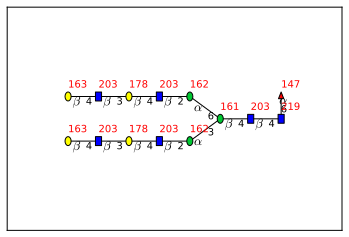

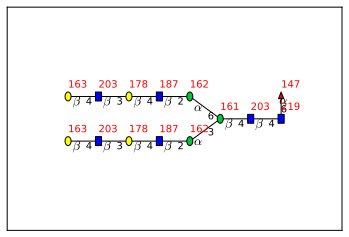

In [68]:
plot.enumerate_tree(*plot.plot(g, label=True, scale=0.1, stretch=1), labeler=lambda x: "%0.0f" % x.mass())
plot.enumerate_tree(*plot.plot(reparse(g), label=True, scale=0.1, stretch=1), labeler=lambda x: "%0.0f" % x.mass())

(RES 1b:b-dglc-HEX-1:5 2s:n-acetyl LIN 1:1d(2+1)2n: id=1  x=0.5 mod=0,
 <matplotlib.axes._subplots.AxesSubplot at 0xae35fd0>)

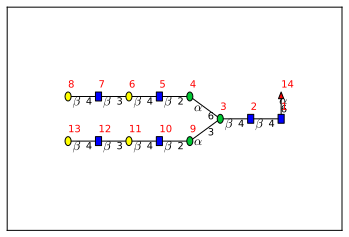

In [22]:
plot.enumerate_tree(*plot.plot(g, label=True, scale=0.1, stretch=1))

In [42]:
reparse(g).get(5).links[4][0].__dict__

DEBUG:glycoct:form_link (Composition({'H': 1, 'O': 1}), Composition({'H': 1}), '1')
DEBUG:glycoct:form_link (Composition({'H': 1}), Composition({'H': 1, 'O': 1}), '2')
DEBUG:glycoct:form_link (Composition({'H': 1}), Composition({'H': 1, 'O': 1}), '3')
DEBUG:glycoct:form_link (Composition({'H': 1, 'O': 1}), Composition({'H': 1}), '4')
DEBUG:glycoct:form_link (Composition({'H': 1}), Composition({'H': 1, 'O': 1}), '5')
DEBUG:glycoct:form_link (Composition({'H': 1}), Composition({'H': 1, 'O': 1}), '6')
DEBUG:glycoct:form_link (Composition({'H': 1}), Composition({'H': 1, 'O': 1}), '7')
DEBUG:glycoct:form_link (Composition({'H': 1}), Composition({'H': 1, 'O': 1}), '8')
DEBUG:glycoct:form_link (Composition({'H': 1, 'O': 1}), Composition({'H': 1}), '9')
INFO:glycoct:Odd Linkage Detected, 10:7x(4+1)9x
DEBUG:glycoct:form_link (Composition({}), Composition({}), '10')
DEBUG:glycoct:form_link (Composition({'H': 1}), Composition({'H': 1, 'O': 1}), '11')
DEBUG:glycoct:form_link (Composition({'H': 1, 

{'_attached': True,
 'child': RES 1b:b-dgal-HEX-1:5,
 'child_loss': Composition({}),
 'child_position': 1,
 'id': 7,
 'label': '-7',
 'parent': RES 1b:b-dglc-HEX-1:5 2s:n-acetyl LIN 1:1d(2+1)2n,
 'parent_loss': Composition({}),
 'parent_position': 4}

187.08445789995